# Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import ndimage as ndi

# Open, convert, and save image as bmp

In [2]:
#filename_to_convert = 'mini_smiley.jpg'
#img_to_convert = cv2.imread(filename_to_convert)
#cv2.imwrite('mini_smiley.bmp', img_to_convert)

# Load Image

image shape: (100, 100, 3)


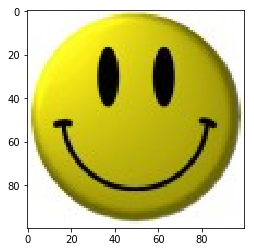

In [3]:
filename = 'mini_smiley.bmp'
img = cv2.imread(filename)
print('image shape: ' + str(img.shape))
imgplot = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Convert to Grayscale

gray image shape: (100, 100)


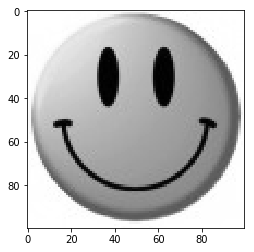

In [16]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print('gray image shape: ' + str(img_gray.shape))
imgplot = plt.imshow(img_gray, cmap='gray')

# Image Gradiants - Sobel

In [5]:
#BORDER_CONSTANT is zero padding
#ddepth CV_16S is 16 bit 

ddepth = cv2.CV_16S
scale = 1
delta = 0
grad_x = cv2.Sobel(img_gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_CONSTANT)

grad_y = cv2.Sobel(img_gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_CONSTANT)

In [6]:
a_padded = np.pad(img_gray, 1, 'constant', constant_values=0)
print(a_padded.shape)

(102, 102)


In [7]:
sobel_kernel_x = np.array([-1, 0, 1, -2, 0, 2, -1, 0, 1], dtype=np.int16).reshape(3,3)
sobel_kernel_y = np.array([1, 2, 1, 0, 0, 0, -1, -2, -1], dtype=np.int16).reshape(3,3)

kernel = sobel_kernel_x

kernel_size = sobel_kernel_x.shape[0]
print('kernel size: ' + str(kernel_size))
#print('Kernel: ')
#print(str(kernel))


#acc= 0

def convolve(a, kernel):
    a = np.asarray(a)
    dest = np.zeros(shape=(a.shape[0]-2, a.shape[1]-2), dtype=np.int16)
    print('dest shape:' + str(dest.shape))
    row_size = dest.shape[0]
    col_size = dest.shape[1]
    print('dest row size: ' + str(dest.shape[0]) + ' dest col size: ' + str(dest.shape[1]))
    for i in range (row_size):
        for j in range (col_size):
            acc = 0          
            
            #print('[' + str(i) + '][' + str(j) + ']')
            #print('Convolution: [' + str(i) + '][' + str(j) + ']')
            
            for k in range (kernel.shape[0]):
                for l in range (kernel.shape[1]):
                    
                    #print('[' + str(k) + '][' + str(l) + ']')
                    #print('kernel element: ' + str(kernel[kernel_size-1-k][kernel_size-1-l]))
                    #print('a element: ' + str(a[i+k][j+l]))
                    
                    acc += kernel[kernel_size-1-k][kernel_size-1-l]*a[i+k][j+l]
                    
            #print('dest[' + str(i) + '][' + str(j) + ']')
            
            dest[i][j] = acc
    return dest

kernel size: 3


In [8]:
grad_x = convolve(a_padded, sobel_kernel_x)
grad_y = convolve(a_padded, sobel_kernel_y)
print(grad_y[0])
print(grad_x[0])
print(np.square(grad_x, dtype=np.int32)[0])
print(np.multiply(grad_x,grad_y, dtype=np.int32)[0])
print(np.square(grad_y, dtype=np.int32)[0])

dest shape:(100, 100)
dest row size: 100 dest col size: 100
dest shape:(100, 100)
dest row size: 100 dest col size: 100


In [9]:
abs_grad_x = cv2.convertScaleAbs(grad_x)
abs_grad_y = cv2.convertScaleAbs(grad_y)


grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

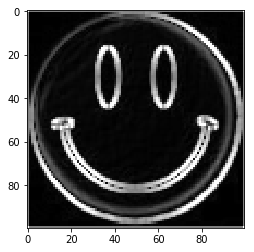

In [10]:
imgplot = plt.imshow(grad, cmap='gray')

# Structure Tensor

In [11]:
def convolve_g(a):
    a = np.asarray(a, dtype=np.longdouble)
    a = np.pad(a, 1, 'constant', constant_values=0)
    
    kernel = np.array([0.063, 0.125, 0.063, 0.125, 0.25, 0.125, 0.063, 0.125, 0.063], 
                          dtype=np.longdouble).reshape(3,3)
    g_kernel_size = kernel.shape[0]
    
    dest = np.zeros(shape=(a.shape[0]-2, a.shape[1]-2), dtype=np.longdouble)
    #print('dest shape:' + str(dest.shape))
    row_size = dest.shape[0]
    col_size = dest.shape[1]
    #print('dest row size: ' + str(dest.shape[0]) + ' dest col size: ' + str(dest.shape[1]))
    for i in range (row_size):
        for j in range (col_size):
            acc = 0          
            
            #print('[' + str(i) + '][' + str(j) + ']')
            #print('Convolution: [' + str(i) + '][' + str(j) + ']')
            
            for k in range (kernel.shape[0]):
                for l in range (kernel.shape[1]):
                    
                    #print('[' + str(k) + '][' + str(l) + ']')
                    #print('kernel element: ' + str(kernel[g_kernel_size-1-k][g_kernel_size-1-l]))
                    #print('a element: ' + str(a[i+k][j+l]))
                    
                    acc += (kernel[g_kernel_size-1-k][g_kernel_size-1-l])*a[i+k][j+l]
                    
            #print('dest[' + str(i) + '][' + str(j) + ']')
            
            dest[i][j] = acc
    return dest

In [12]:
Ixx = convolve_g(np.square(grad_x, dtype=np.int32))
Iyy = convolve_g(np.square(grad_y, dtype=np.int32))
Ixy = convolve_g(np.multiply(grad_x,grad_y, dtype=np.int32))

# Harris Response Calculation

In [13]:
# R = det(M)-k*tr(M)^2
k = 0.04

det = (Ixx * Iyy) - (Ixy**2)
trace = Ixx + Iyy
r = det - np.multiply(k,(np.square(trace, dtype=np.longdouble)),dtype=np.longdouble)

# Non-maximum Suppression - Threshold

44411757875.41591
254


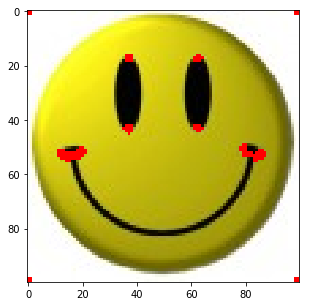

In [14]:
# Threshold
corners = np.argwhere(r>0.01*(r.max()))
print(r.max())
print(np.size(corners))

# Show image:
img_harris1 = img.copy()
img_harris1[r>0.01*(r.max())]=[0,0,255]
plt.figure(figsize = (5,5))
imgplot = plt.imshow(cv2.cvtColor(img_harris1, cv2.COLOR_BGR2RGB))

# Non-maximum Suppression - Remove neighbors

Shape of filtered coords array: (8, 2)


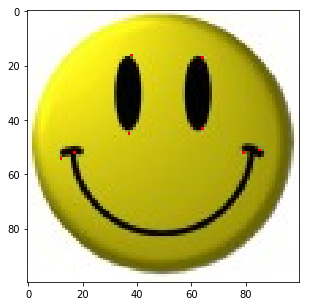

In [15]:
# Inspired by http://www.kaij.org/blog/?p=89
min_distance = 5
candidate_values = [r[c[0]][c[1]] for c in corners]

#sort candidates
index = np.argsort(candidate_values)

#store allowed point locations in array
allowed_locations = np.zeros(r.shape)
allowed_locations[min_distance:-min_distance,min_distance:-min_distance] = 1

#select the best points taking min_distance into account
filtered_coords = []
for i in index:
    if allowed_locations[corners[i][0]][corners[i][1]] == 1:
        filtered_coords.append(corners[i])
        allowed_locations[(corners[i][0]-min_distance):(corners[i][0]+min_distance),
            (corners[i][1]-min_distance):(corners[i][1]+min_distance)] = 0
print('Shape of filtered coords array: ' + str(np.array(filtered_coords).shape))


# Show image:
img_harris2 = img.copy()
for c in filtered_coords:
    img_harris2[c[0]][c[1]]=[0,0,255]
plt.figure(figsize = (5,5))
imgplot = plt.imshow(cv2.cvtColor(img_harris2, cv2.COLOR_BGR2RGB))